In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def categorized_col(df,car_th=20,num_th=10):
  #bu fonksiyon ile featureları kategorik,numeric ve cardinal olarak sınıflandırıyorum.
  #Bu sınıflandırma sayesinde daha sonrasında bu kategoriler üzerinde uygun işlemleri yapabileceğim.
  cat_col = []
  num_col = []
  car_col = []
  for col in df.columns:
    if df[col].dtype in ["object","category","boolean"]:
      if df[col].nunique() < car_th:
        cat_col.append(col)
      else:
        car_col.append(col) #kategorik olarak görülse de unique etkisi olmayan featurelar için.
    else: #df[col].dtype in ["int","float"]:
      if df[col].nunique() < num_th:
        cat_col.append(col)
      else:
        num_col.append(col)

  print(f"rows: {df.shape[0]}")
  print(f"columns: {df.shape[1]}")
  print(f"categorical columns: {len(cat_col)}")
  print(f"numerical columns: {len(num_col)}")
  print(f"cardinal columns: {len(car_col)}\n")

  return cat_col,num_col,car_col

def info_col(df):
  #bu fonksiyonda sınıflandırılan featureları, yapılarını anlamak amacıyla türlerine göre inceliyor bu da datanın yapısını anlamamda yardım ediyor.
  cat_col,num_col,car_col = categorized_col(df)

  for col in df:
    if col in cat_col:
      print(f"{col}'s info:\n {df[col].value_counts()}",end="\n\n")
    elif col in num_col:
      print(f"{col}'s info:\n {df[col].describe([0.25,0.50,0.75,0.99])}",end="\n\n") #outlier olabilecek değerlerin varlığını anlayabilmek için 0.99 değerini de quantilelara ekledim.
    else:
      print(f"{col} is a cardinal column.\n")

In [ ]:
def outlier_thresholds(data,col,q1=0.25,q3=0.75):
  #outlierları yakalamak için iqr yöntemini kullanıyorum, bu fonksiyon da yöntemin thresholdlarını hesaplıyor.
  #default olarak q1 ve q3 quantilelarına verdiğim değerler outlierları ne genişlikte arayacağımla ilgili.
  #daha dar aralıklar için 0.05-0.95, 0.01-0.99 gibi değerler de verilebilir.
  q11 = data[col].quantile(q1)
  q33 = data[col].quantile(q3)

  iqr = q33-q11

  low = q11-1.5*iqr
  up = q33+iqr*1.5

  return low,up


def find_outliers(data,col,q1=0.25,q3=0.75):
  #hesaplanan thresholdlar ile verilen featureda outlier değer olup olmadığını kontrol ediyor.
  low,up = outlier_thresholds(data,col,q1,q3)

  if data[(data[col]<low)|(data[col]>up)].any(axis=None):
    return True
  else:
    return False

def replace_outliers(data,col,q1=0.25,q3=0.75):
  #outlier saptanan featuredaki outlierı threshold değerleriyle değiştiriyor.
  low,up = outlier_thresholds(data,col,q1,q3)
  data.loc[data[col]<low,col] = low
  data.loc[data[col]>up,col] = up



In [ ]:
data = pd.read_csv('/content/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
data.shape

(1338, 7)

In [ ]:
info_col(data) #featureların genel yapısını inceleniyorum.

rows: 1338
columns: 7
categorical columns: 4
numerical columns: 3
cardinal columns: 0

age's info:
 count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
99%        64.000000
max        64.000000
Name: age, dtype: float64

sex's info:
 male      676
female    662
Name: sex, dtype: int64

bmi's info:
 count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
25%        26.296250
50%        30.400000
75%        34.693750
99%        46.407900
max        53.130000
Name: bmi, dtype: float64

children's info:
 0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

smoker's info:
 no     1064
yes     274
Name: smoker, dtype: int64

region's info:
 southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

charges's info:
 count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25

In [ ]:
data.isna().sum() #datada nan değer olup olmadığını kontrol ediyorum. hiç nan değer yokmuş, şanslıyız :).

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

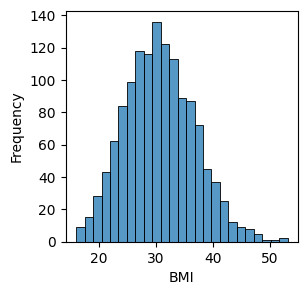

In [ ]:
#featurelar daha ayrıntılı olarak inceleniyorum.

#bmi featureının dağılımı:

plt.figure(figsize=(3,3))
sns.histplot(data=data,x='bmi')
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.show()

#grafik ile bmi featureının 30 değeri çevresinde en yoğun olduğunu ve normale yakın bir dağılım gösterdiğini görüyoruz.

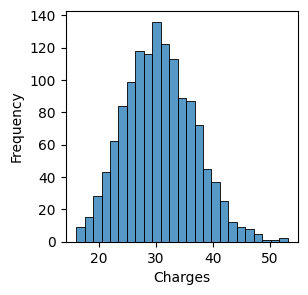

In [ ]:
#charges target featureın dağılımı:.

plt.figure(figsize=(3,3))
sns.histplot(data=data,x='bmi')
plt.xlabel("Charges")
plt.ylabel("Frequency")
plt.show()

#charges faeture'ı 30k çevresinde yoğunlaşan normale yakın bir dağılım gösteriyor.

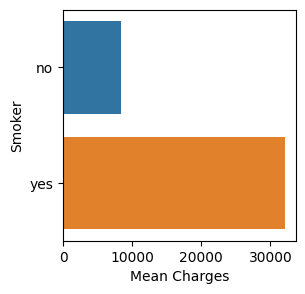

In [ ]:
#smoker featureı ve charges target featureı arasındaki ilişki:

df = data.groupby('smoker').agg({'charges':'mean'}).reset_index()

plt.figure(figsize=(3,3))
sns.barplot(x='charges',y='smoker',data=df)
plt.xlabel("Mean Charges")
plt.ylabel("Smoker")
plt.show()
#smoker kategorik feature olduğundan sınıflarına göre ortalama charges değerini inceledim. bu grafiğe göre sigara içenlerin daha yüksek medical costları olduğunu görüyoruz.

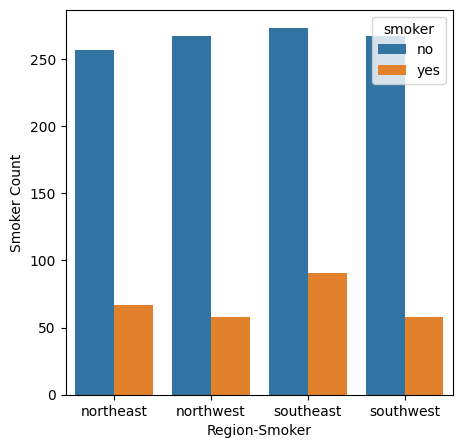

In [ ]:
#smoker ve region featureları arasındaki ilişki:

df = data.groupby(['region','smoker']).agg({'smoker':'count'})
df.columns = ['count']
df = df.reset_index()

plt.figure(figsize=(5,5))
sns.barplot(x='region',y='count',hue='smoker',data=df)
plt.xlabel("Region-Smoker")
plt.ylabel("Smoker Count")
plt.show()
#grafikten her reigonda sigara içmeyenlerin sayısının içenlere göre daha az olduğunu görüyoruz.

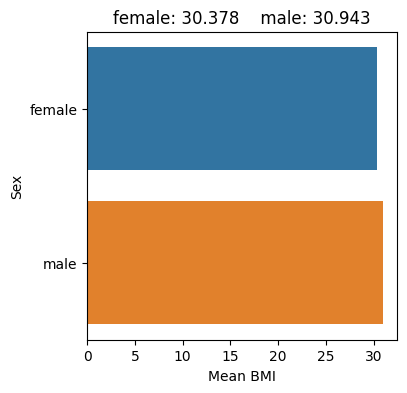

In [ ]:
#bmi ve sex featureları arasındaki ilişki:

df = data.groupby('sex').agg({'bmi':'mean'}).reset_index()

plt.figure(figsize=(4,4))
sns.barplot(x='bmi',y='sex',data=df)
plt.xlabel("Mean BMI")
plt.ylabel("Sex")
plt.title(f"female: {round(df.loc[0,'bmi'],3)}    male: {round(df.loc[1,'bmi'],3)}")
plt.show()

#sex kategorik ve bmi numeric olduğundan sexe göre gruplandırıp bmi'ın ortalamasına baktım.
#grafikten female ve male ortalama bmilarının birbirine çok yakın olduğu, male'in az farkla daha yüksek olduğu anlaşılıyor.

In [ ]:
df = data.groupby('region').agg({'children':'sum'}).reset_index()
df.loc[df['children']==df['children'].max()]
#en çok çocuğun olduğu region, south east.

,region,children
2,southeast,382


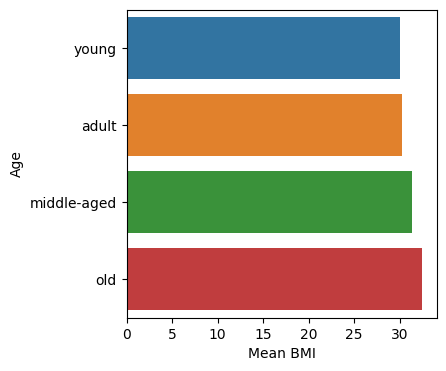

young: 30.00735294117647	 adult: 30.232077067669174	 middle-aged: 31.319572127139363	 old: 32.441813186813185


In [ ]:
#bmi ve age featureları arasındaki ilişki:
#bmi ve age featureları numeric olduklarından ötürü aralarındaki ilişkiyi inceleyebilmek için age featureını sınıflara ayırmaya karar verdim.

df = pd.DataFrame(pd.cut(data['age'],[15,25,45,60,90],labels=["young","adult","middle-aged","old"])) #datadaki yaş değerlerine göre yaş featureına bir sınıflandırma yaptım.
df['bmi'] = data['bmi'] #bmi feature'ı da yeni dataframe ekledim.

df1 = df.groupby("age").agg({'bmi':'mean'}).reset_index()

plt.figure(figsize=(4,4))
sns.barplot(x='bmi',y='age',data=df1)
plt.xlabel("Mean BMI")
plt.ylabel("Age")
plt.show()

print(f"young: {df1.loc[0,'bmi']}\t adult: {df1.loc[1,'bmi']}\t middle-aged: {df1.loc[2,'bmi']}\t old: {df1.loc[3,'bmi']}")

#age featureına göre sınıflandırma yapıp bmi ortalamalarına baktım.
#grafikten yaş aralıklarında bmi değerlerinin yakın olduğun ancak yaşlı kesimde biraz daha yüksek olduğu görülüyor. yaş arttıkça bmi artıyor sonucu çıkarılabilir.

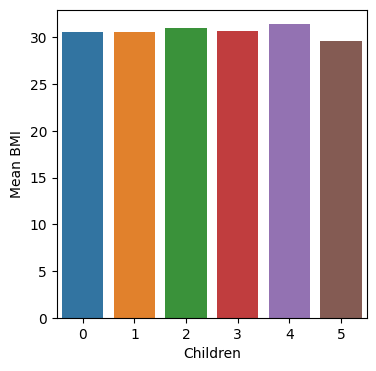

0: 30.550296167247385	 1: 30.623148148148147	 2: 30.978104166666665	 3: 30.68433121019108	 4: 31.391199999999998	 5: 29.605


In [ ]:
#children ve bmi featureları arasındaki ilişki:

df = data.groupby('children').agg({'bmi':'mean'}).reset_index()

plt.figure(figsize=(4,4))
sns.barplot(x='children',y='bmi',data=df)
plt.xlabel("Children")
plt.ylabel("Mean BMI")
plt.show()

print(f"0: {df.loc[0,'bmi']}\t 1: {df.loc[1,'bmi']}\t 2: {df.loc[2,'bmi']}\t 3: {df.loc[3,'bmi']}\t 4: {df.loc[4,'bmi']}\t 5: {df.loc[5,'bmi']}")

#children kategorik olduğundan sınıflarının ortalama bmi değerlerine baktım.
#sahip olunan çocuk sayısının bmi'ı önemli ölçüde etkilemediği yorumu yapılabilir.

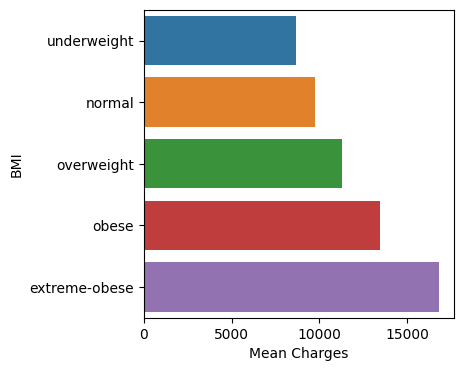

underweight: 16884.924	 normal: 1725.5523	 overweight: 4449.462	 obese: 21984.47061	 extreme-obese: 3866.8552


In [ ]:
#bmi ve charges featureları arasındaki ilişki:
#ikisi de numeric feature olduğundan, bmi'ı değişkenlerine göre sınıflandırıp ilişkilerini incelemeye karar verdim.

df = pd.DataFrame(pd.cut(data['bmi'],[0,19,24,29,34,60],labels=["underweight","normal","overweight","obese","extreme-obese"])) #bmi değerlerine göre sınıflandırma yapıldı.
df['charges'] = data['charges']

df1 = df.groupby('bmi').agg({'charges':'mean'}).reset_index()

plt.figure(figsize=(4,4))
sns.barplot(x='charges',y='bmi',data=df1)
plt.xlabel("Mean Charges")
plt.ylabel("BMI")
plt.show()

print(f"underweight: {df.loc[0,'charges']}\t normal: {df.loc[1,'charges']}\t overweight: {df.loc[2,'charges']}\t obese: {df.loc[3,'charges']}\t extreme-obese: {df.loc[4,'charges']}")

#bmi sınıfları ortalama charge değerlerine göre inceledim.
#bmi arttıkça medical costların da arttığı yorumu yapılabilir.

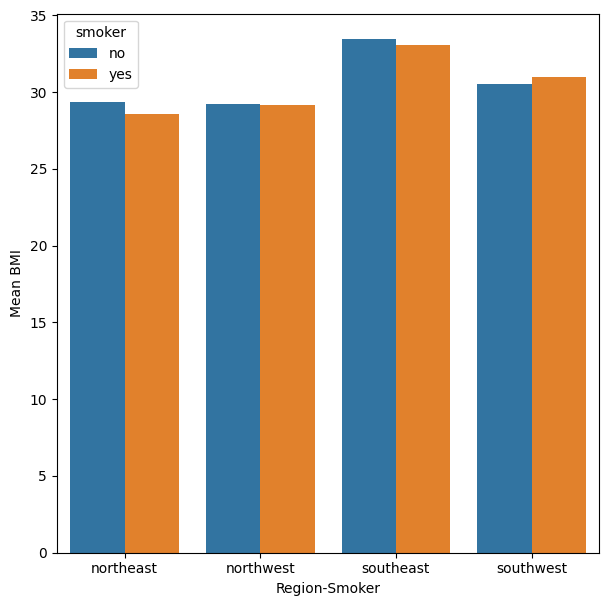

In [ ]:
#region,smoker ve bmi featureları arasındaki ilişki:

df = data.groupby(['region','smoker']).agg({'bmi':'mean'}).reset_index()

plt.figure(figsize=(7,7))
sns.barplot(x='region',y='bmi',hue='smoker',data=df)
plt.xlabel("Region-Smoker")
plt.ylabel("Mean BMI")
plt.show()

#region ve smoker sınıfları bmi ortalamalarına göre inceledim.
#south east bölgesinde bmi'ın daha yüksek olduğunu ve genel olarak sigara içmeyenlerin daha yüksek bmi'a sahip oldukları yorumu yapılabilir.

In [ ]:
#sıra outlier kontrolüne geliyor, outlier kontrolünü numeric featurelarda yapacağımdan datadaki numeric columnları seçiyorum.
cat_col,num_col,car_col = categorized_col(data)
num_col

rows: 1338
columns: 7
categorical columns: 4
numerical columns: 3
cardinal columns: 0



['age', 'bmi', 'charges']

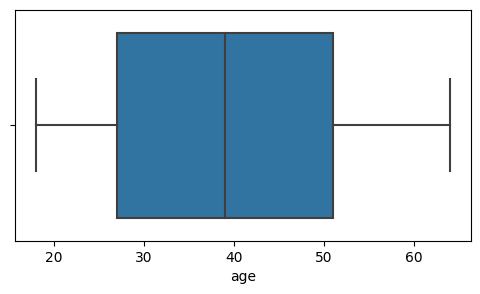

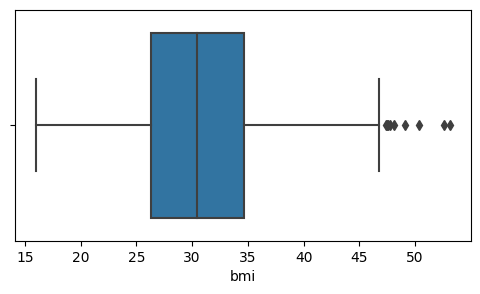

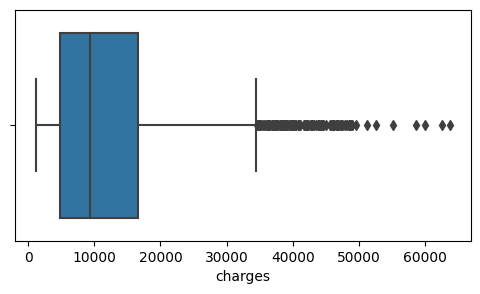

In [ ]:
#önce numeric featureların boxplotlarına bakalım.

for i in range(len(num_col)):
  plt.figure(figsize=(20,3))
  plt.subplot(1,3,i+1)
  sns.boxplot(x=num_col[i],data=data)
  plt.show()

#grafiklerde görüldüğü üzere age featureında outlier değer gözlenmezken, bmi ve charge featurelarında outlier değere rastlanmıştır.

In [ ]:
#notebook başında tanımladığım outlier fonksiyonlarıyla outlierları bulup, modelin daha iyi çalışması için baskılıyorum.
outlier_col = [] #iqr yöntemine göre outlierı olan columnları tutacak liste
for col in num_col:
  if find_outliers(data,col):
    outlier_col.append(col)
outlier_col #hangi featurelarda outlier değerleri var kontrol ediliyor.

['bmi', 'charges']

In [ ]:
#outlierlar threshold değerleriyle değiştiriliyor.
#charges için q1=0.15 ve q3=0.85 değerleri için outlier detection ve replace yapıyorum çünkü charges feature'ında 0.25-0.75 değerleri için fazla outlier detect edildi.
#bu değerlerde baskılamak datayı etkileyebileceğinden daha uçlarda outlier arıyorum.
replace_outliers(data,'charges',q1=0.15,q3=0.85)
replace_outliers(data,'bmi') #bmi için 0.25-0.75 değerleri için outlier detection ve replace yapıyorum.

#outlierlar baskılandı mı kontrol edelim.
print("charges: ",find_outliers(data,'charges',q1=0.15,q3=0.85))
print("bmi: ",find_outliers(data,'bmi'))

#bmi ve charges değişkenlerindeki outlierları baskıladım.

charges:  False
bmi:  False


In [ ]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
#model çalışırken kullanışlı olabileceğinden biraz feature engineering yapıyorum.

data['bmi_flag'] = pd.cut(data['bmi'],[0,19,24,29,34,60],labels=["underweight","normal","overweight","obese","extreme-obese"]) #bmi için kategorik feature oluşturuyorum.
data['age_flag'] = pd.cut(data['age'],[15,25,45,60,90],labels=["young","adult","middle-aged","old"]) #age için kategorik feature oluşturuyorum.

data.head() #datanın son haline bakalım.

,age,sex,bmi,children,smoker,region,charges,bmi_flag,age_flag
0,19,female,27.900,0,yes,southwest,16884.92400,overweight,young
1,18,male,33.770,1,no,southeast,1725.55230,obese,young
2,28,male,33.000,3,no,southeast,4449.46200,obese,adult
3,33,male,22.705,0,no,northwest,21984.47061,normal,adult
4,32,male,28.880,0,no,northwest,3866.85520,overweight,adult


In [ ]:
#gelecek aşamalarda kullanmak için columnları yeniden kategorize ediyorum.

cat_col,num_col,car_col = categorized_col(data)

rows: 1338
columns: 9
categorical columns: 6
numerical columns: 3
cardinal columns: 0



In [ ]:
#numeric columnları modelin daha iyi çalışması için scale ediyorum.
from sklearn.preprocessing import MinMaxScaler

num_col.remove('charges') #scale edeceğim numeric columnlar içinde target variable charges da olduğu için onu çıkarıyorum.

for col in num_col:
  data[col] = MinMaxScaler().fit_transform(data[[col]]) #MinMaxScaler ile numeric columnları scale ediyorum.

data.head() #datanın son haline bakalım.

,age,sex,bmi,children,smoker,region,charges,bmi_flag,age_flag
0,0.021739,female,0.381104,0,yes,southwest,16884.92400,overweight,young
1,0.000000,male,0.568465,1,no,southeast,1725.55230,obese,young
2,0.217391,male,0.543888,3,no,southeast,4449.46200,obese,adult
3,0.326087,male,0.215289,0,no,northwest,21984.47061,normal,adult
4,0.304348,male,0.412384,0,no,northwest,3866.85520,overweight,adult


In [ ]:
#kategorik columnları modlein anlayabilmesi için encode ediyorum.
#pandas kütüphanesinde get_dummies methodunu one hot encoder olarak kullanıyorum, methoddaki drop_first parametresiyle binary columnları da encode etmiş oluyorum.

data = pd.get_dummies(data,columns=cat_col,drop_first=True)

data.head() #datanın son haline bakalım.

,age,bmi,charges,sex_male,children_1,children_2,children_3,children_4,children_5,smoker_yes,region_northwest,region_southeast,region_southwest,bmi_flag_normal,bmi_flag_overweight,bmi_flag_obese,bmi_flag_extreme-obese,age_flag_adult,age_flag_middle-aged,age_flag_old
0,0.021739,0.381104,16884.92400,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0
1,0.000000,0.568465,1725.55230,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,0.217391,0.543888,4449.46200,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0
3,0.326087,0.215289,21984.47061,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
4,0.304348,0.412384,3866.85520,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0


In [ ]:
#datayı target ve diğer featurelara bölüyorum.

x = data.drop('charges',axis=1)
y = data['charges']

In [ ]:
#modellerin train aşaması:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor

#modelleri base halleriyle kuruyorum, hyperparametre optimizasyonunu daha sonra yapacağım.
lr_model = LinearRegression().fit(x_train,y_train)
knn_model = KNeighborsRegressor().fit(x_train,y_train)
rf_model = RandomForestRegressor(random_state=13).fit(x_train,y_train)
gbm_model = GradientBoostingRegressor(random_state=13).fit(x_train,y_train)
lgbm_model = LGBMRegressor(random_state=13).fit(x_train,y_train)
#modeller için random_state ayarladım ki her çalıştırdığımda aynı sonuçları alıp yorum yapabileyim.

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 332
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 18
[LightGBM] [Info] Start training from score 13463.480155


In [ ]:
#cross validation ile modellerin data üzerindeki başarısını değerlendiriyorum.
from sklearn.model_selection import cross_validate

lr_cv = cross_validate(lr_model,x,y,scoring=['r2','neg_mean_squared_error'],cv=5,n_jobs=-1)
knn_cv = cross_validate(knn_model,x,y,scoring=['r2','neg_mean_squared_error'],cv=5,n_jobs=-1)
rf_cv = cross_validate(rf_model,x,y,scoring=['r2','neg_mean_squared_error'],cv=5,n_jobs=-1)
gbm_cv = cross_validate(gbm_model,x,y,scoring=['r2','neg_mean_squared_error'],cv=5,n_jobs=-1)
lgbm_cv = cross_validate(lgbm_model,x,y,scoring=['r2','neg_mean_squared_error'],cv=5,n_jobs=-1)

print(f"**LINEAR REGRESSION**\n R2: {lr_cv['test_r2'].mean()} MSE: {lr_cv['test_neg_mean_squared_error'].mean()}")
print(f"**KNN**\n R2: {knn_cv['test_r2'].mean()} MSE: {knn_cv['test_neg_mean_squared_error'].mean()}")
print(f"**RandomForest**\n R2: {rf_cv['test_r2'].mean()} MSE: {rf_cv['test_neg_mean_squared_error'].mean()}")
print(f"**GBM**\n R2: {gbm_cv['test_r2'].mean()} MSE: {gbm_cv['test_neg_mean_squared_error'].mean()}")
print(f"**LGBM**\n R2: {lgbm_cv['test_r2'].mean()} MSE: {lgbm_cv['test_neg_mean_squared_error'].mean()}")
#r2 ve mse skorlarına göre en başarılı modeller gbm ve lgbm'i seçiyorum.

**LINEAR REGRESSION**
 R2: 0.7525760065472006 MSE: -35832486.44035917
**KNN**
 R2: 0.5714422509921385 MSE: -62341988.6948631
**RandomForest**
 R2: 0.8320451123855825 MSE: -24211467.52107524
**GBM**
 R2: 0.8542916369434908 MSE: -21003349.803572673
**LGBM**
 R2: 0.840948152212551 MSE: -22940480.54101456


In [ ]:
#seçtiğim modellerin parametrelerine bakıp grid search cv ile hyperparametre optimizasyonu yapıyorum.
gbm_model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 13,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
gbm_params = {'learning_rate':[0.1,0.05],'min_samples_split':[2,5,8],'n_estimators':[100,200,300]} #hiperparametreler seçip grid search içinde denenecek değerlerini atıyorum.

In [ ]:
lgbm_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': 13,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [ ]:
lgbm_params = {'learning_rate':[0.1,0.05],'n_estimators':[100,200,300],'colsample_bytree':[1.0,0.8]}

In [ ]:
from sklearn.model_selection import GridSearchCV #grid search cv ile hiperparametre optimizasyonu yapıyorum.

gbm_grid_cv = GridSearchCV(gbm_model,gbm_params,cv=5,n_jobs=-1).fit(x_train,y_train)
lgbm_grid_cv = GridSearchCV(lgbm_model,lgbm_params,cv=5,n_jobs=-1).fit(x_train,y_train)

print(gbm_grid_cv.best_params_)
print(lgbm_grid_cv.best_params_)
#modellerin test edilen hiperparametrelerdeki best değerlerini buldum.

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 332
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 18
[LightGBM] [Info] Start training from score 13463.480155
{'learning_rate': 0.05, 'min_samples_split': 5, 'n_estimators': 100}
{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'n_estimators': 100}


In [ ]:
#elde edilen best parametreleri final modelleri oluşturmak için kullanıyorum.

gbm_final = gbm_model.set_params(**gbm_grid_cv.best_params_,random_state=13).fit(x_train,y_train)
lgbm_final = lgbm_model.set_params(**lgbm_grid_cv.best_params_,random_state=13).fit(x_train,y_train)

#final modellere yeniden r2 ve mse metricleriyle cross validate uyguluyorum.

gbm_cv2 = cross_validate(gbm_model,x,y,scoring=['r2','neg_mean_squared_error'],cv=5,n_jobs=-1)
lgbm_cv2 = cross_validate(lgbm_model,x,y,scoring=['r2','neg_mean_squared_error'],cv=5,n_jobs=-1)

print("BEFORE")
print(f"**GBM**\n R2: {gbm_cv['test_r2'].mean()} MSE: {gbm_cv['test_neg_mean_squared_error'].mean()}")
print(f"**LGBM**\n R2: {lgbm_cv['test_r2'].mean()} MSE: {lgbm_cv['test_neg_mean_squared_error'].mean()}\n")

print("AFTER")
print(f"**GBM**\n R2: {gbm_cv2['test_r2'].mean()} MSE: {gbm_cv2['test_neg_mean_squared_error'].mean()}")
print(f"**LGBM**\n R2: {lgbm_cv2['test_r2'].mean()} MSE: {lgbm_cv2['test_neg_mean_squared_error'].mean()}\n")
#model başarısının hiperparametre optimizasyonu ile arttığını görüyoruz.

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 332
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 18
[LightGBM] [Info] Start training from score 13463.480155
BEFORE
**GBM**
 R2: 0.8542916369434908 MSE: -21003349.803572673
**LGBM**
 R2: 0.840948152212551 MSE: -22940480.54101456

AFTER
**GBM**
 R2: 0.8603742012224395 MSE: -20109062.415440798
**LGBM**
 R2: 0.8511727376464865 MSE: -21475051.208481513



In [ ]:
#voting regresor ile modelleri kombine edebiliriz.
from sklearn.ensemble import VotingRegressor

vr_model = VotingRegressor(estimators=[('GBM',gbm_final),('LGBM',lgbm_final)]).fit(x_train,y_train) #modelleri birleştiriyorum.

vr_cv = cross_validate(vr_model,x,y,scoring=['r2','neg_mean_squared_error'],cv=5,n_jobs=-1) #cross validation ile modelin başarısına bakıyorum.


print(f"*****VOTINGREGRESSOR*****\nR2: {vr_cv['test_r2'].mean()}\t MSE: {vr_cv['test_neg_mean_squared_error'].mean()}\n")
#gbm modelinin başarısı, voting regressor ile oluşturulan modelin başarısından yüksek olduğundan gbm'i son model olarak seçiyorum.

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 332
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 18
[LightGBM] [Info] Start training from score 13463.480155
*****VOTINGREGRESSOR*****
R2: 0.8587564950499059	 MSE: -20359317.627649076

